<a href="https://colab.research.google.com/github/VictoKu1/Anomaly_Detection/blob/master/Task1_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection**

---

**Moriya Bitton || Victor Kushnir**

In [44]:
# Imports

import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## **Part 1 - Data** 

---



---



In [45]:
from google.colab import files

data_to_load = files.upload()
target_to_load = files.upload()

Saving conn_attack.csv to conn_attack.csv


Saving conn_attack_anomaly_labels.csv to conn_attack_anomaly_labels.csv


In [46]:
# Reading the data and fixing columns names

import io

df = pd.read_csv(io.BytesIO(data_to_load['conn_attack.csv']), 
                 names=["record_id", "duration_", "src_bytes", "dst_bytes"], 
                 index_col='record_id')
columns = df.columns

target = pd.read_csv(io.BytesIO(target_to_load['conn_attack_anomaly_labels.csv']), 
                 names=["id", "label"], 
                 index_col='id')

In [47]:
df.head()

,duration_,src_bytes,dst_bytes
record_id,,,
1,0,236,1228
2,0,239,486
3,0,234,1364
4,0,239,1295
5,0,181,5450


In [48]:
target.head()

,label
id,
1,0
2,0
3,0
4,0
5,0


##### **Shape**

In [49]:
df.shape

(256670, 3)

In [50]:
columns.shape

(3,)

In [51]:
target.shape

(256670, 1)

##### **Analyzing the data frame** 

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256670 entries, 1 to 256670
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   duration_  256670 non-null  int64
 1   src_bytes  256670 non-null  int64
 2   dst_bytes  256670 non-null  int64
dtypes: int64(3)
memory usage: 7.8 MB


In [53]:
df.describe()

,duration_,src_bytes,dst_bytes
count,256670.000000,256670.000000,2.566700e+05
mean,0.640936,474.247898,4.473533e+03
std,15.627170,3391.106084,2.080903e+04
min,0.000000,0.000000,0.000000e+00
25%,0.000000,217.000000,6.600000e+02
50%,0.000000,249.000000,1.661000e+03
75%,0.000000,306.000000,4.341000e+03
max,3289.000000,54540.000000,7.068759e+06


##### **Data visualization**

[Text(0.5, 1.0, 'dst_bytes')]

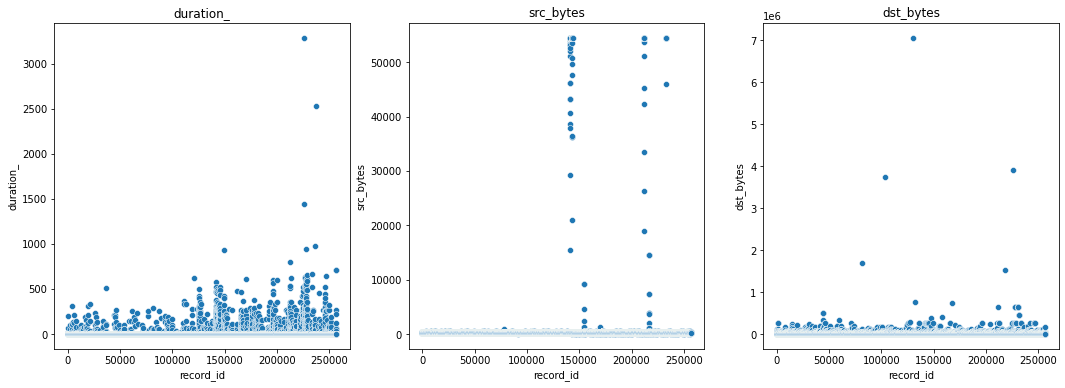

In [54]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# Data distributed only on the "duration_" feature 
sns.scatterplot(data=df.duration_, ax=axes[0]).set(title="duration_")

# Data distributed only on the "src_bytes" feature 
sns.scatterplot(data=df.src_bytes, ax=axes[1]).set(title="src_bytes")

# Data distributed only on the "dst_bytes" feature 
sns.scatterplot(data=df.dst_bytes, ax=axes[2]).set(title="dst_bytes")

## **Part 2 - Possible labels to compare**

---



---



##### **Assumption**

Essentially, we want to find ways to locate outliers without relying on any model to find the most appropriate model.


I found that the clustering algorithm will probably work because the data is mostly clustered in the center and only a small amount is scattered far away from it. As a result, isolation forests won't work, but DB SCAN will.

In [99]:
q = df.duration_.quantile(0.99)
q_low_1 = df.duration_.quantile(0.01)
q_hi_1 = df.duration_.quantile(0.99)

q = df.src_bytes.quantile(0.99)
q_low_2 = df.src_bytes.quantile(0.01)
q_hi_2  = df.src_bytes.quantile(0.99)

q = df.duration_.quantile(0.99)
q_low_3 = df.dst_bytes.quantile(0.01)
q_hi_3  = df.dst_bytes.quantile(0.99)

# creating the guess
guess = np.zeros_like(df.src_bytes)

guess[(df.duration_>q_hi_1) | (df.duration_<q_low_1) | 
      (df.src_bytes>q_hi_2) | (df.src_bytes<q_low_2) | 
      (df.dst_bytes>q_hi_3) | (df.dst_bytes<q_low_3)] = 1 

## **Part 3 - Models**


---



---




In [100]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [101]:
# Finding important features

df1 = df.drop(columns=columns[0])
df2 = df.drop(columns=columns[1])
df3 = df.drop(columns=columns[2])

df4 = df.drop(columns=[columns[0], columns[1]])
df5 = df.drop(columns=[columns[0], columns[2]])
df6 = df.drop(columns=[columns[1], columns[2]])

### **Part 3.1 - Isolation Forest**


In [102]:
from sklearn.ensemble import IsolationForest

# Find if Isolation Forest might have good prediction
def run_if_models(max_f_, df):
  isf_prediction = []
  for i in range(100, 1000, 100):
      isf = IsolationForest(n_estimators=i, max_features=max_f_, n_jobs=-1)
      isf_labels = pd.Series(isf.fit_predict(df))
      isf_labels = isf_labels.map({1: 0, -1: 1})
      isf_prediction.append([i, f1_score(y_true=guess, y_pred=isf_labels)])

  sns.lineplot(x=np.array(isf_prediction)[:, 0], y=np.array(isf_prediction)[:, 1])  

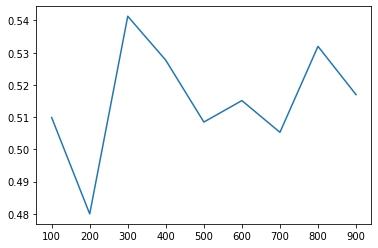

In [103]:
# Running the model using all features

run_if_models(3, df)

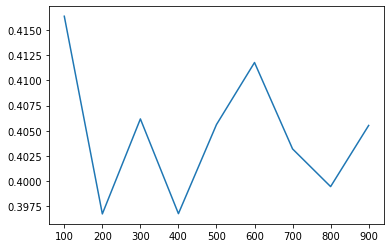

In [104]:
# Running the model without "duration"

run_if_models(2, df1)

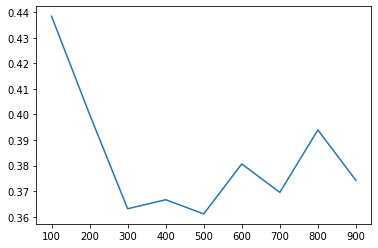

In [105]:
# Running the model without "src_bytes"

run_if_models(2, df2)

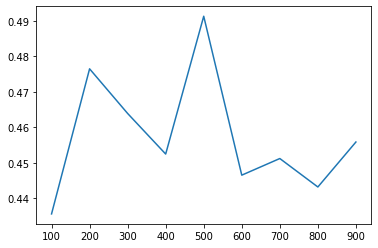

In [106]:
# Running the model without "dst_bytes"

run_if_models(2, df3)

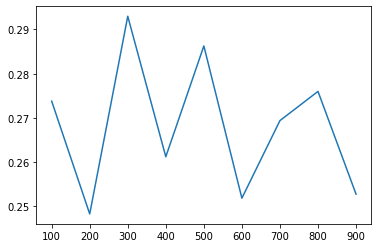

In [107]:
# Running the model without "duration" , "src_bytes"

run_if_models(1, df4)

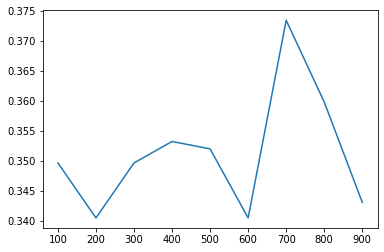

In [108]:
# Running the model without "duration" , "dst_bytes"

run_if_models(1, df5)

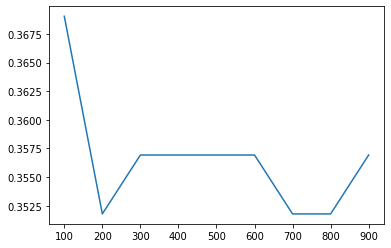

In [109]:
# Running the model without "src_bytes" , "dst_bytes"

run_if_models(1, df6)

### **Part 3.2 - DBSCAN**

In [110]:
from sklearn.cluster import DBSCAN

# Mapping fuction to fit the correct labels
def _map(x):
    if x == -1:
        return 0
    return 1

# find if DBSCAN might have good prediction.
def run_dbs_models(df):
  dbs_prediction = []
  for i in range(50, 300, 50):
      dbs = DBSCAN(min_samples=i)
      dbs_labels = pd.Series(dbs.fit_predict(df))
      dbs_labels = dbs_labels.apply(lambda x: _map(x))
      dbs_prediction.append([i, f1_score(y_true=guess, y_pred=dbs_labels)])

  sns.lineplot(x=np.array(dbs_prediction)[:, 0], y=np.array(dbs_prediction)[:, 1])

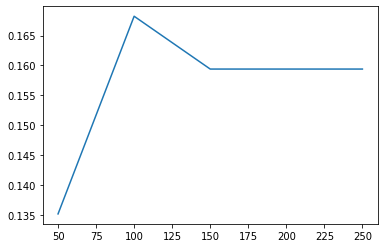

In [111]:
# Running the model using all features

run_dbs_models(df)

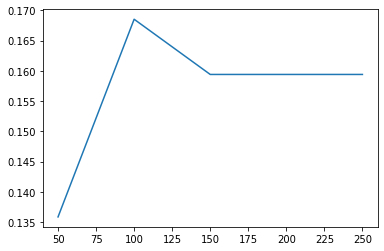

In [112]:
# Running the model without "duration"

run_dbs_models(df1)

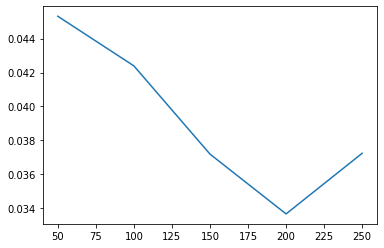

In [113]:
# Running the model without "src_bytes"

run_dbs_models(df2)

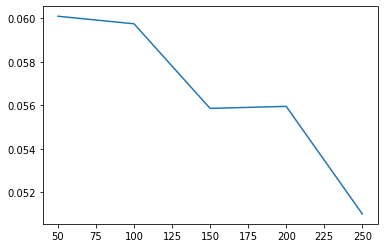

In [114]:
# Running the model without "dst_bytes"

run_dbs_models(df3)

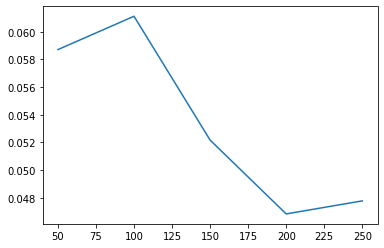

In [115]:
# Running the model without "duration" , "src_bytes"

run_dbs_models(df4)

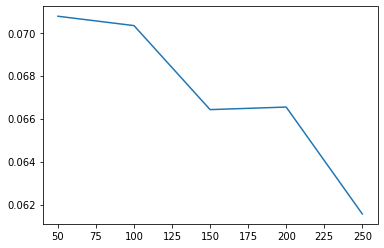

In [116]:
# Running the model without "duration" , "dst_bytes"

run_dbs_models(df5)

In [117]:
# Running the model without "src_bytes" , "dst_bytes"

# run_dbs_models(df6) --> Memory error!

## **Part 4 - Model evaluation and comparison**

---



In [118]:
from sklearn.metrics import plot_confusion_matrix

In [119]:
DBS = DBSCAN(min_samples=150, n_jobs=-1)
DBS_labels = pd.Series(DBS.fit_predict(df)).apply(lambda x: _map(x))

##### **Evaluation:** y_guess & y_DB_Scan

In [120]:
confusion_matrix(y_true=guess, y_pred=DBS_labels)

array([[245608,      0],
       [ 10104,    958]])

In [121]:
print(classification_report(y_true=guess, y_pred=DBS_labels))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    245608
           1       1.00      0.09      0.16     11062

    accuracy                           0.96    256670
   macro avg       0.98      0.54      0.57    256670
weighted avg       0.96      0.96      0.94    256670



##### **Evaluation:** y_guess & y_true

In [122]:
confusion_matrix(y_true=guess, y_pred=target.label)

array([[245608,      0],
       [ 10040,   1022]])

In [123]:
print(classification_report(y_true=guess, y_pred=target.label))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    245608
           1       1.00      0.09      0.17     11062

    accuracy                           0.96    256670
   macro avg       0.98      0.55      0.57    256670
weighted avg       0.96      0.96      0.95    256670



##### **Evaluation:** y_DB_Scan & y_true

In [124]:
confusion_matrix(y_true=DBS_labels, y_pred=target.label)

array([[255648,     64],
       [     0,    958]])

In [125]:
print(classification_report(y_true=DBS_labels, y_pred=target.label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    255712
           1       0.94      1.00      0.97       958

    accuracy                           1.00    256670
   macro avg       0.97      1.00      0.98    256670
weighted avg       1.00      1.00      1.00    256670



## **Part 5 - Export the output**

---


In [126]:
df["true label"] = target.label

DBS_labels = DBS_labels.set_axis(target.index)
df["is_anomaly"] = DBS_labels

df_out = df.drop(columns=[columns[0], columns[1], columns[2]])

In [127]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256670 entries, 1 to 256670
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   true label      256670 non-null  int64
 1   DBS_prediction  256670 non-null  int64
dtypes: int64(2)
memory usage: 5.9 MB


In [128]:
df_out.describe()

,true label,DBS_prediction
count,256670.000000,256670.000000
mean,0.003982,0.003732
std,0.062976,0.060980
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [129]:
df_out.corr()

,true label,DBS_prediction
true label,1.000000,0.968062
DBS_prediction,0.968062,1.000000


In [130]:
df_out.to_csv('output.csv', encoding='utf-8', index=False)

## **Part 6 - Conclusion**

---

*   According to the F_scores, the isolation forest is not the right solution.

*   DBSCAN does fit this problem

*   While "src_bytes" is the most important feature, utilizing all features helps detect outliers more effectively.

*   Our guesses weren't accurate.

*   There is a high correlation between the real label and the prediction, which means that the prediction is very close to the real label. 

